# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D $SU(3)$ model

Uses `torch.complex128` by default

## Setup

In [1]:
import lovely_tensors as lt
lt.monkey_patch()
lt.set_config(color=False)

In [2]:
%load_ext autoreload
%autoreload 2
# automatically detect and reload local changes to modules
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
import os
from pathlib import Path
from typing import Optional

import lovely_tensors as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

import l2hmc.group.su3.pytorch.group as g
from l2hmc.utils.rich import get_console
from l2hmc.common import grab_tensor, print_dict
from l2hmc.configs import dict_to_list_of_overrides, get_experiment
from l2hmc.experiment.pytorch.experiment import Experiment, evaluate  # noqa  # noqa
from l2hmc.utils.dist import setup_torch
from l2hmc.utils.plot_helpers import set_plot_style

os.environ['COLORTERM'] = 'truecolor;'
os.environ['MASTER_PORT'] = '5433'
# os.environ['MPLBACKEND'] = 'module://matplotlib-backend-kitty'
# plt.switch_backend('module://matplotlib-backend-kitty')
console = get_console()

_ = setup_torch(precision='float64', backend='DDP', seed=4351)

set_plot_style()

from l2hmc.utils.plot_helpers import (  # noqa
    set_plot_style,
    plot_scalar,
    plot_chains,
    plot_leapfrogs
)

def savefig(fig: plt.Figure, fname: str, outdir: os.PathLike):
    pngfile = Path(outdir).joinpath(f"pngs/{fname}.png")
    svgfile = Path(outdir).joinpath(f"svgs/{fname}.svg")
    pngfile.parent.mkdir(exist_ok=True, parents=True)
    svgfile.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(svgfile, transparent=True, bbox_inches='tight')
    fig.savefig(pngfile, transparent=True, bbox_inches='tight', dpi=300)

def plot_metrics(metrics: dict, title: Optional[str] = None, **kwargs):
    outdir = Path(f"./plots-4dSU3/{title}")
    outdir.mkdir(exist_ok=True, parents=True)
    for key, val in metrics.items():
        fig, ax = plot_metric(val, name=key, **kwargs)
        if title is not None:
            ax.set_title(title)
        console.log(f"Saving {key} to {outdir}")
        savefig(fig, f"{key}", outdir=outdir)
        plt.show()

def plot_metric(
        metric: torch.Tensor,
        name: Optional[str] = None,
        **kwargs,
):
    assert len(metric) > 0
    if isinstance(metric[0], (int, float, bool, np.floating)):
        y = np.stack(metric)
        return plot_scalar(y, ylabel=name, **kwargs)
    element_shape = metric[0].shape
    if len(element_shape) == 2:
        y = grab_tensor(torch.stack(metric))
        return plot_leapfrogs(y, ylabel=name)
    if len(element_shape) == 1:
        y = grab_tensor(torch.stack(metric))
        return plot_chains(y, ylabel=name, **kwargs)
    if len(element_shape) == 0:
        y = grab_tensor(torch.stack(metric))
        return plot_scalar(y, ylabel=name, **kwargs)
    raise ValueError

[07/10/23 07:55:42][INFO][dist.py:226] - Caught MASTER_PORT:5433 from environment!
[07/10/23 07:55:42][WARNING][dist.py:332] - Setting default dtype: float64
[07/10/23 07:55:42][INFO][dist.py:338] - Global Rank: 0 / 0


## Load config + build Experiment

In [4]:
from rich import print
set_plot_style()

from l2hmc.configs import CONF_DIR
su3conf = Path(f"{CONF_DIR}/su3-min.yaml")
with su3conf.open('r') as stream:
    conf = dict(yaml.safe_load(stream))
console.log(conf)

[07:55:42] {                                                                                                       
               'annealing_schedule': {'beta_final': 6.0, 'beta_init': 6.0},                                        
               'backend': 'DDP',                                                                                   
               'conv': 'none',                                                                                     
               'dynamics': {                                                                                       
                   'eps': 0.001,                                                                                   
                   'eps_fixed': False,                                                                             
                   'group': 'SU3',                                                                                 
                   'latvolume': [4, 4, 4, 8],                                                                      
                   'nchains': 4,                                                                                   
                   'nleapfrog': 4,                                                                                 
                   'use_separate_networks': False,                                                                 
                   'use_split_xnets': False,                                                                       
                   'verbose': True                                                                                 
               },                                                                                                  
               'framework': 'pytorch',                                                                             
               'init_aim': False,                                                                                  
               'init_wandb': False,                                                                                
               'learning_rate': {'clip_norm': 1.0, 'lr_init': 1e-05},                                              
               'loss': {'charge_weight': 0.0, 'plaq_weight': 0.0, 'rmse_weight': 1.0, 'use_mixed_loss': False},    
               'net_weights': {'v': {'q': 1.0, 's': 1.0, 't': 1.0}, 'x': {'q': 0.0, 's': 0.0, 't': 0.0}},          
               'network': {'activation_fn': 'tanh', 'dropout_prob': 0.0, 'units': [1], 'use_batch_norm': False},   
               'restore': False,                                                                                   
               'save': False,                                                                                      
               'steps': {'log': 1, 'nepoch': 10, 'nera': 1, 'print': 1, 'test': 50},                               
               'use_tb': False,                                                                                    
               'use_wandb': False                                                                                  
           }

In [5]:
overrides = dict_to_list_of_overrides(conf)
ptExpSU3 = get_experiment(overrides=[*overrides], build_networks=True)
state = ptExpSU3.trainer.dynamics.random_state(6.0)
console.log(f"checkSU(state.x): {g.checkSU(state.x)}")
assert isinstance(state.x, torch.Tensor)
assert isinstance(state.beta, torch.Tensor)
assert isinstance(ptExpSU3, Experiment)

[07/10/23 07:55:42][INFO][dist.py:226] - Caught MASTER_PORT:5433 from environment!
[07/10/23 07:55:42][INFO][dist.py:226] - Caught MASTER_PORT:5433 from environment!
[07/10/23 07:55:42][WARNING][trainer.py:436] - Using `torch.optim.Adam` optimizer
[07/10/23 07:55:42][INFO][trainer.py:284] - num_params in model: 401420
[07/10/23 07:55:42][WARNING][trainer.py:250] - logging with freq 1 for wandb.watch


           checkSU(state.x): (tensor[4] f64 x∈[2.174e-07, 3.981e-07] μ=3.044e-07 σ=7.432e-08 grad SqrtBackward0    
           [2.174e-07, 3.981e-07, 3.107e-07, 2.914e-07], tensor[4] f64 x∈[4.942e-06, 1.187e-05] μ=8.282e-06        
           σ=2.848e-06 grad SqrtBackward0 [4.942e-06, 1.187e-05, 8.531e-06, 7.784e-06])

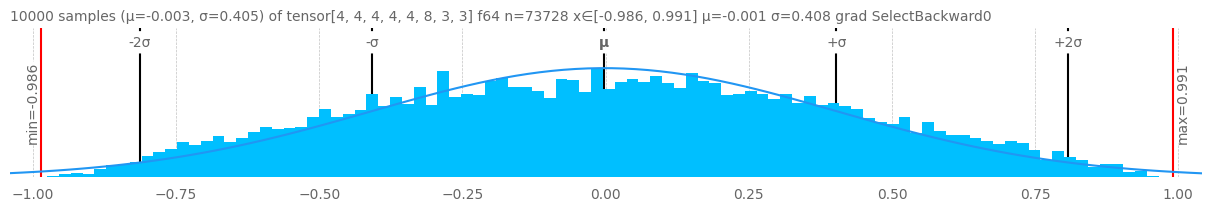

In [6]:
state.x.real.plt()

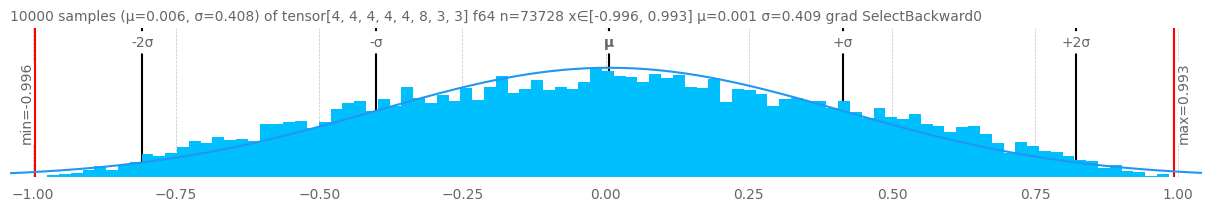

In [7]:
state.x.imag.plt()

## HMC

[07/10/23 07:56:30][INFO][experiment.py:115] - Running 50 steps of hmc at beta=6.0000
[07/10/23 07:56:30][INFO][experiment.py:119] - STEP: 0
[07/10/23 07:56:30][INFO][experiment.py:119] - STEP: 1
[07/10/23 07:56:30][INFO][experiment.py:119] - STEP: 2
[07/10/23 07:56:30][INFO][experiment.py:119] - STEP: 3
[07/10/23 07:56:30][INFO][experiment.py:119] - STEP: 4
[07/10/23 07:56:30][INFO][experiment.py:119] - STEP: 5
[07/10/23 07:56:30][INFO][common.py:97] - energy: torch.Size([2, 4]) torch.float64 
[[-1455.17436446 -1652.1514185  -1517.90987068 -1455.94178323]
 [-1459.25165577 -1657.51842424 -1524.14091372 -1460.98822723]]
logprob: torch.Size([2, 4]) torch.float64 
[[-1455.17436446 -1652.1514185  -1517.90987068 -1455.94178323]
 [-1459.25165577 -1657.51842424 -1524.14091372 -1460.98822723]]
logdet: torch.Size([2, 4]) torch.float64 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
acc: torch.Size([4]) torch.float64 
[1. 1. 1. 1.]
sumlogdet: torch.Size([4]) torch.float64 
[0. 0. 0. 0.]
acc_mask: torch.Size([4]

[07:56:33] checkSU(x_hmc): (tensor[4] f64 x∈[3.429e-16, 3.484e-16] μ=3.453e-16 σ=2.351e-18 [3.442e-16, 3.484e-16,  
           3.429e-16, 3.458e-16], tensor[4] f64 x∈[1.072e-15, 1.171e-15] μ=1.136e-15 σ=4.386e-17 [1.143e-15,       
           1.157e-15, 1.072e-15, 1.171e-15])

           Saving energy to plots-4dSU3/HMC

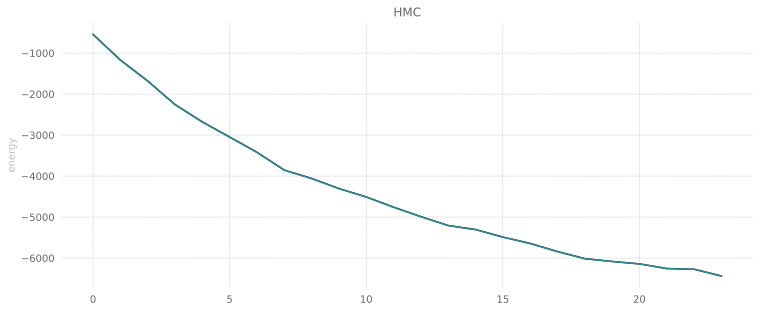

           Saving logprob to plots-4dSU3/HMC

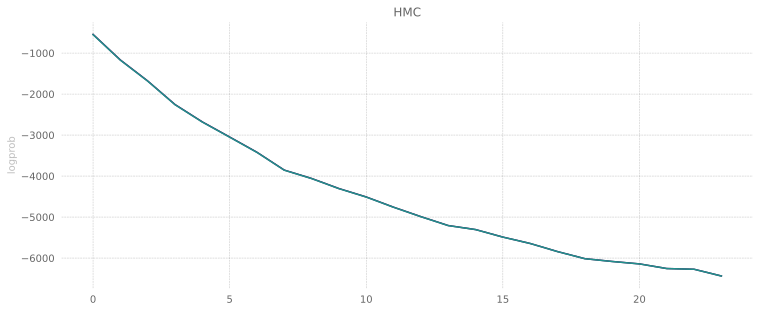

           Saving logdet to plots-4dSU3/HMC

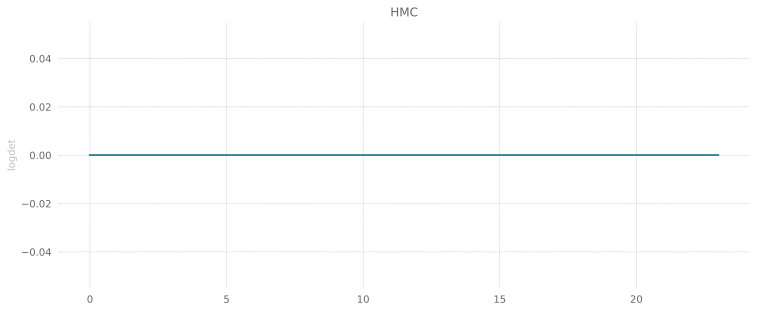

           Saving acc to plots-4dSU3/HMC

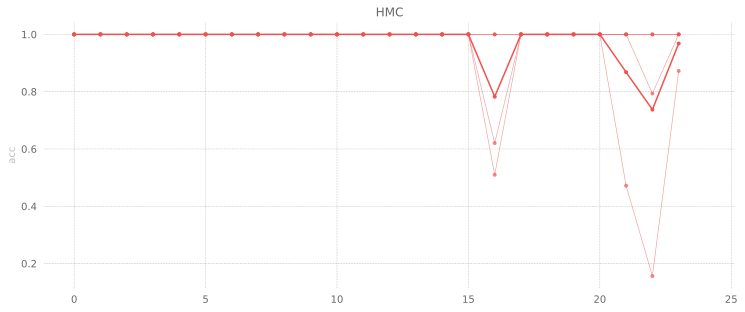

           Saving sumlogdet to plots-4dSU3/HMC

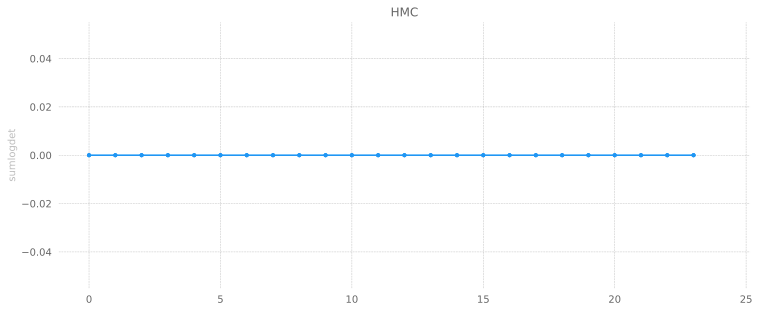

[07:56:34] Saving acc_mask to plots-4dSU3/HMC

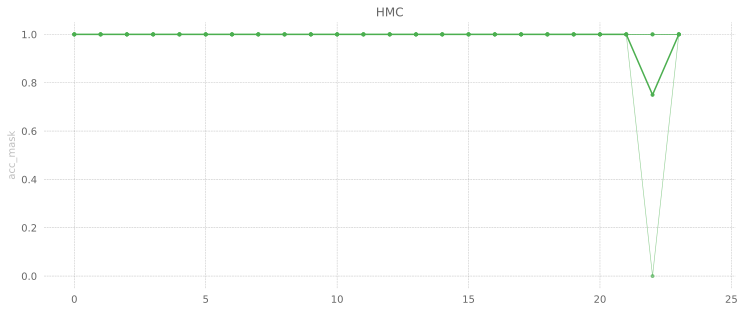

           Saving plaqs to plots-4dSU3/HMC

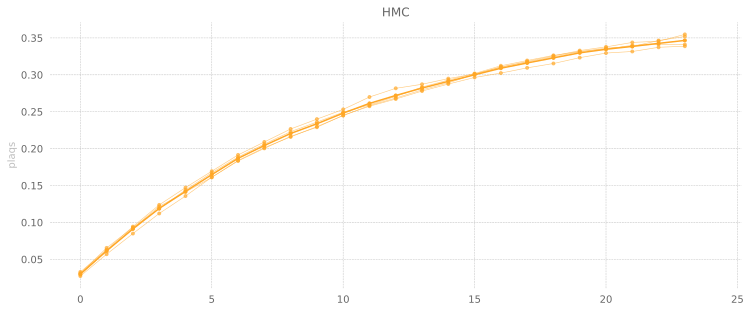

           Saving sinQ to plots-4dSU3/HMC

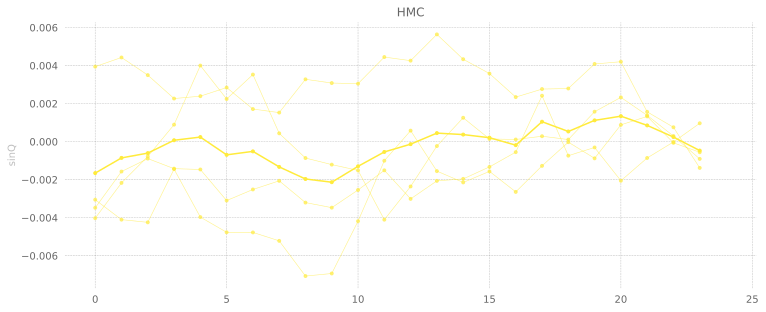

           Saving intQ to plots-4dSU3/HMC

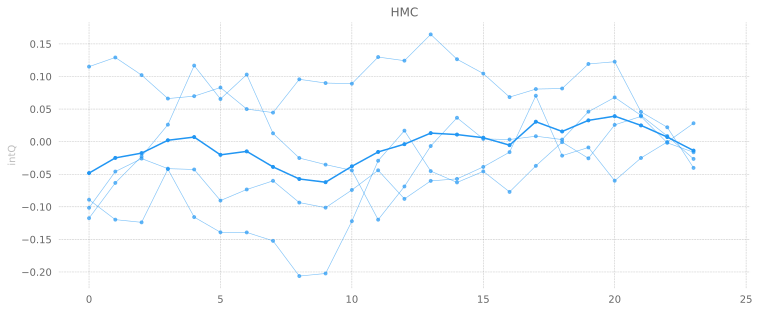

[07:56:35] Saving dQint to plots-4dSU3/HMC

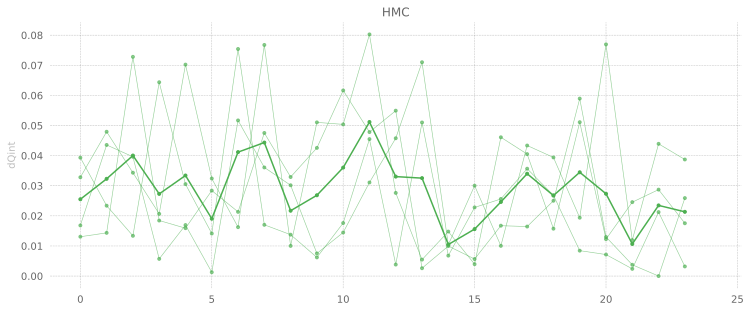

           Saving dQsin to plots-4dSU3/HMC

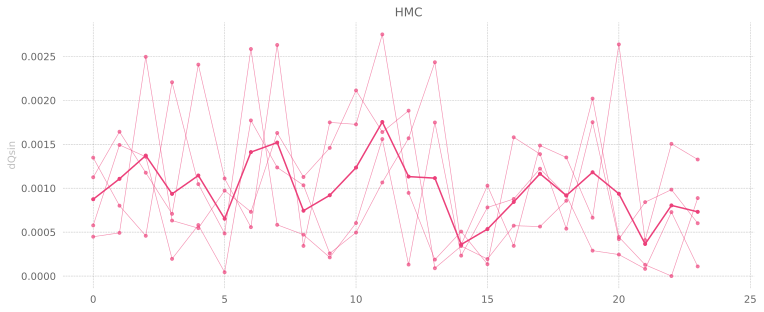

           Saving loss to plots-4dSU3/HMC

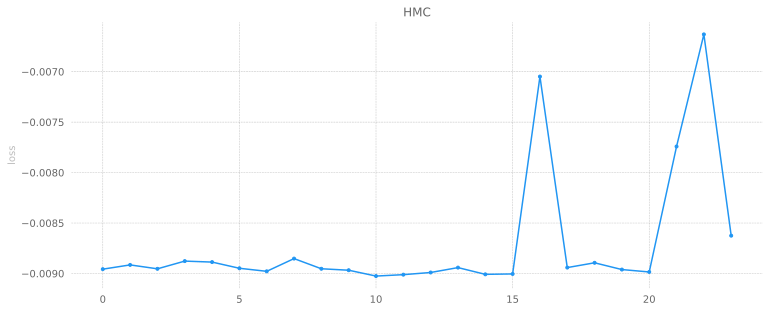

In [8]:
xhmc, history_hmc = evaluate(
    nsteps=50,
    exp=ptExpSU3,
    beta=state.beta,
    x=state.x,
    eps=0.1,
    nleapfrog=1,
    job_type='hmc',
    nlog=2,
    nprint=5,
    grab=True
)
xhmc = ptExpSU3.trainer.dynamics.unflatten(xhmc)
console.log(f"checkSU(x_hmc): {g.checkSU(xhmc)}")
plot_metrics(history_hmc, title='HMC', marker='.')

## Evaluation

[07/10/23 07:56:45][INFO][experiment.py:115] - Running 50 steps of eval at beta=6.0000
[07/10/23 07:56:45][INFO][experiment.py:119] - STEP: 0
[07/10/23 07:56:46][INFO][experiment.py:119] - STEP: 1
[07/10/23 07:56:46][INFO][experiment.py:119] - STEP: 2
[07/10/23 07:56:46][INFO][experiment.py:119] - STEP: 3
[07/10/23 07:56:47][INFO][experiment.py:119] - STEP: 4
[07/10/23 07:56:47][INFO][experiment.py:119] - STEP: 5
[07/10/23 07:56:48][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[135.13661105 -33.63307096  67.14737865 -44.94287792]
 [135.12019559 -33.67474968  67.13262028 -45.06121746]
 [135.11640715 -33.7029591   67.13542667 -45.15853882]
 [135.12597508 -33.71582603  67.15528762 -45.23443416]
 [135.15009837 -33.71282679  67.19223232 -45.28949862]
 [135.24409668 -33.55745988  67.28977981 -45.05889668]
 [135.35293374 -33.38888138  67.40388327 -44.8080029 ]
 [135.47661625 -33.20710601  67.53407019 -44.53600603]
 [135.61403391 -33.01043184  67.68099845 -44.24220592]]
log

[07:57:06] checkSU(x_eval): (tensor[4] f64 x∈[3.845e-16, 3.993e-16] μ=3.923e-16 σ=6.436e-18 [3.955e-16, 3.845e-16, 
           3.901e-16, 3.993e-16], tensor[4] f64 x∈[1.405e-15, 1.560e-15] μ=1.496e-15 σ=6.503e-17 [1.560e-15,       
           1.405e-15, 1.511e-15, 1.507e-15])

           Saving energy to plots-4dSU3/Evaluate

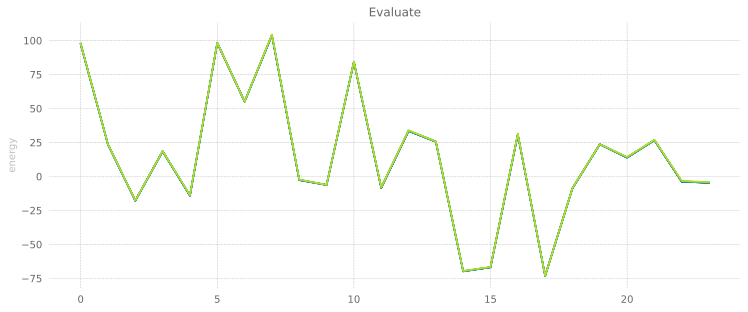

           Saving logprob to plots-4dSU3/Evaluate

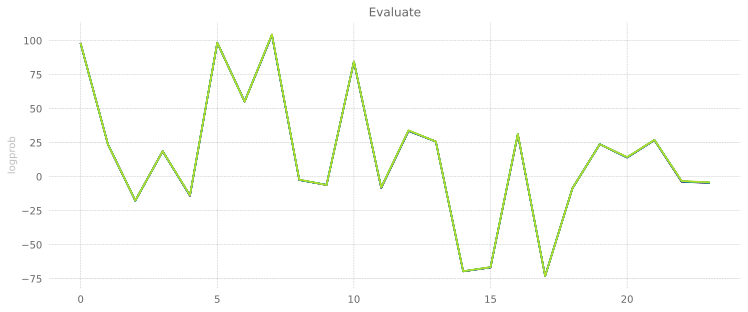

[07:57:07] Saving logdet to plots-4dSU3/Evaluate

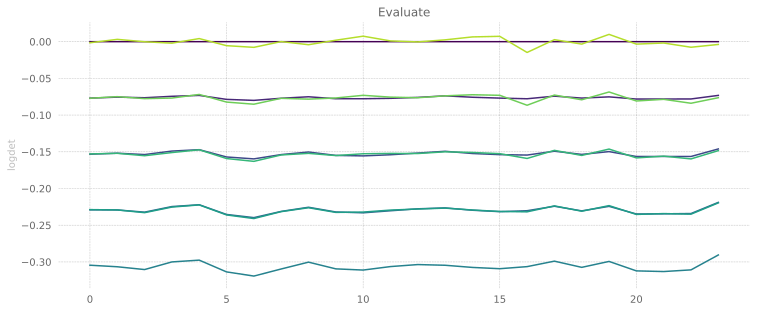

           Saving sldf to plots-4dSU3/Evaluate

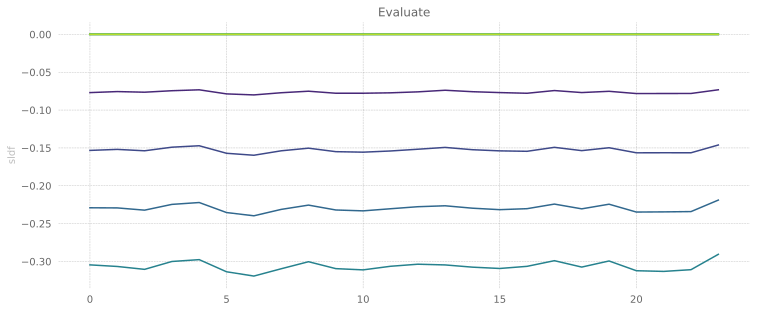

           Saving sldb to plots-4dSU3/Evaluate

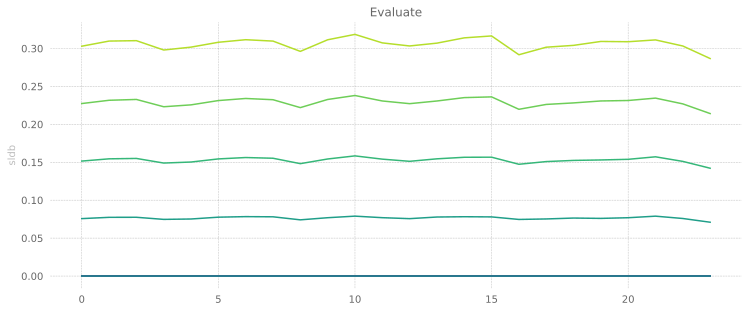

           Saving sld to plots-4dSU3/Evaluate

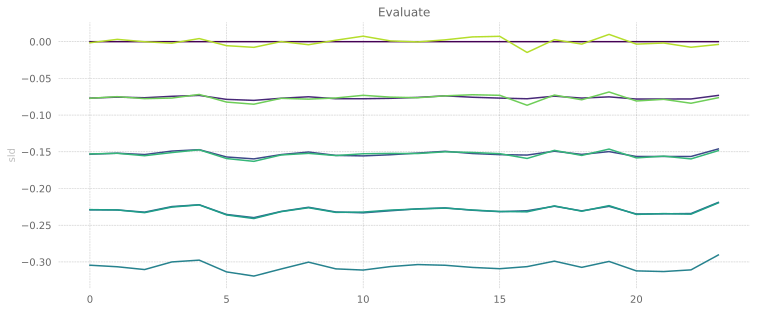

[07:57:08] Saving xeps to plots-4dSU3/Evaluate

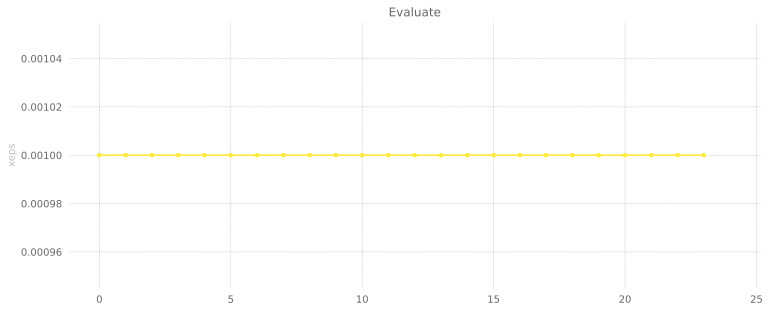

           Saving veps to plots-4dSU3/Evaluate

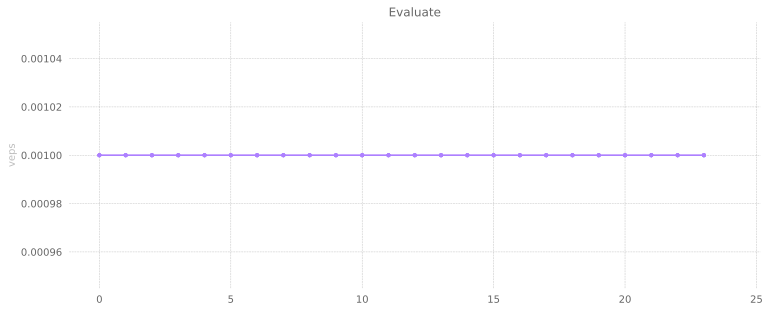

           Saving acc to plots-4dSU3/Evaluate

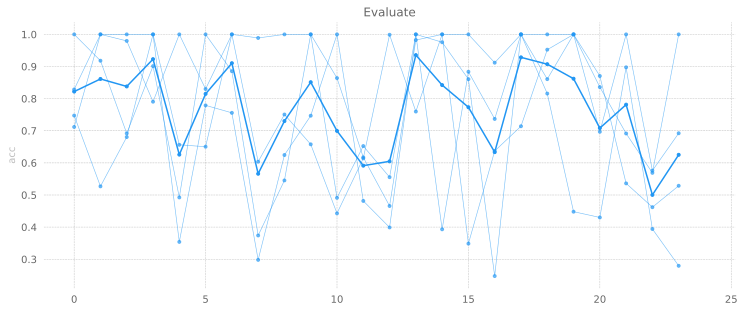

           Saving sumlogdet to plots-4dSU3/Evaluate

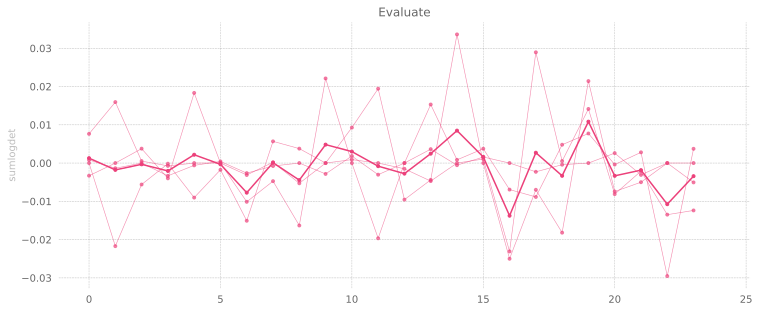

[07:57:09] Saving beta to plots-4dSU3/Evaluate

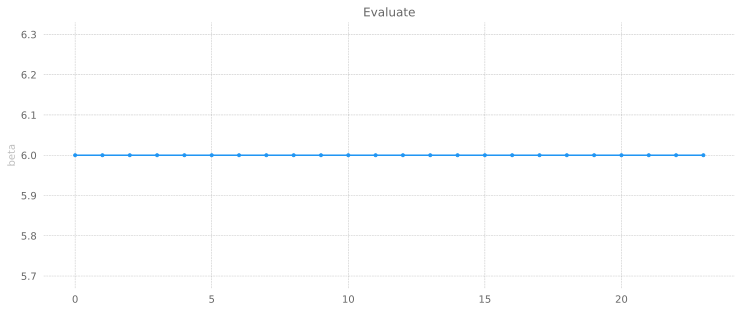

           Saving acc_mask to plots-4dSU3/Evaluate

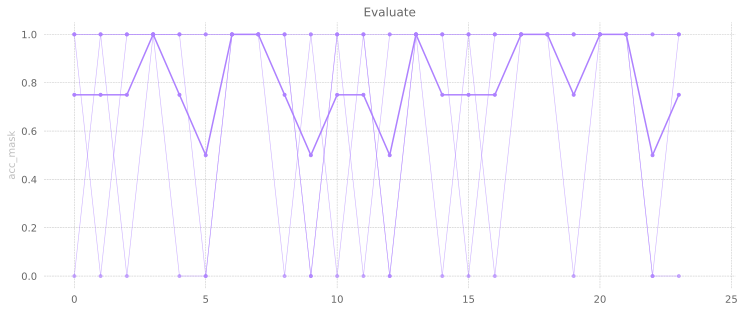

           Saving plaqs to plots-4dSU3/Evaluate

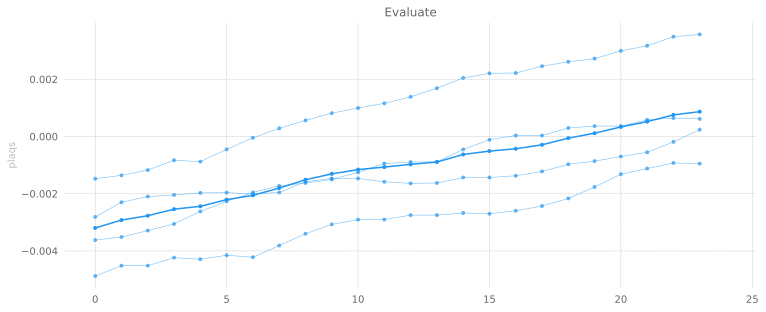

           Saving sinQ to plots-4dSU3/Evaluate

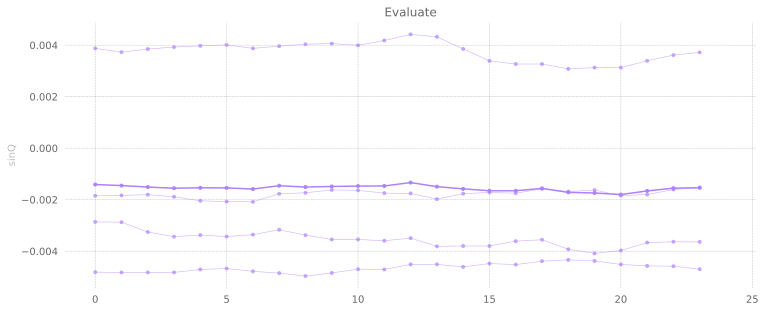

[07:57:10] Saving intQ to plots-4dSU3/Evaluate

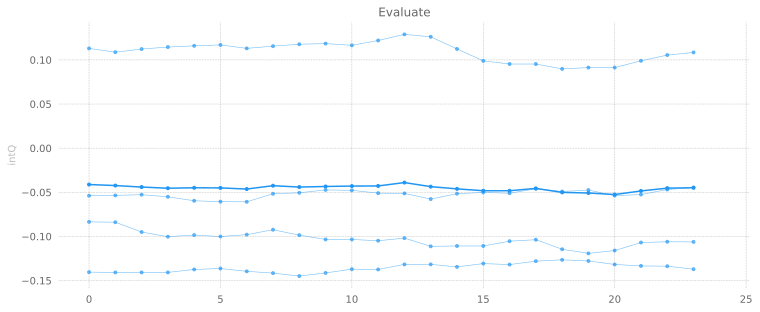

           Saving dQint to plots-4dSU3/Evaluate

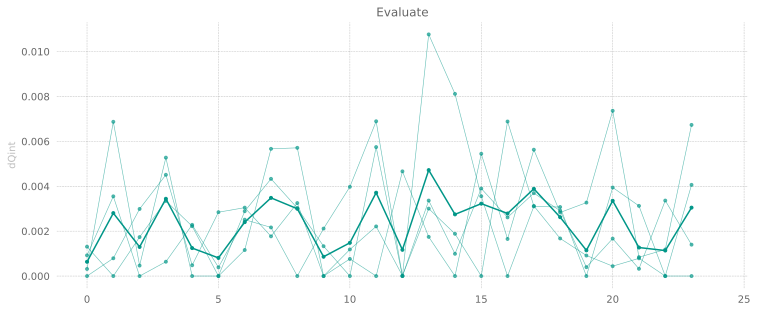

           Saving dQsin to plots-4dSU3/Evaluate

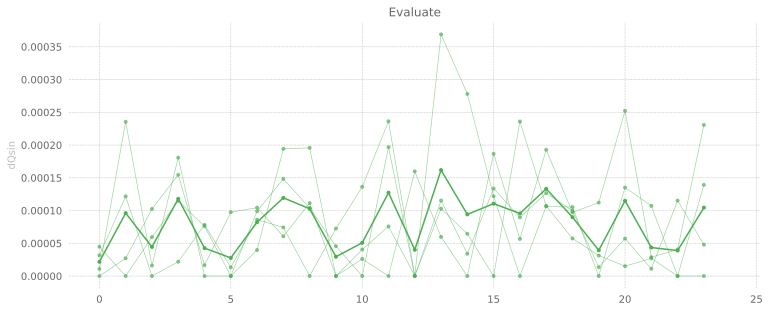

[07:57:11] Saving loss to plots-4dSU3/Evaluate

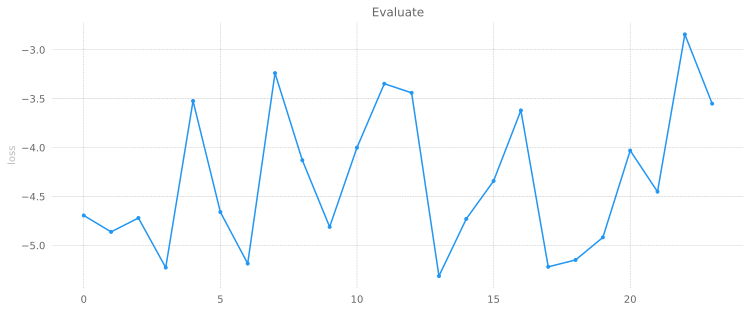

In [9]:
# ptExpSU3.trainer.dynamics.init_weights(
#     method='uniform',
#     min=-1e-16,
#     max=1e-16,
#     bias=True,
#     # xeps=0.001,
#     # veps=0.001,
# )
xeval, history_eval = evaluate(
    nsteps=50,
    exp=ptExpSU3,
    beta=6.0,
    x=state.x,
    job_type='eval',
    nlog=2,
    nprint=5,
    grab=True,
)
xeval = ptExpSU3.trainer.dynamics.unflatten(xeval)
console.log(f"checkSU(x_eval): {g.checkSU(xeval)}")
plot_metrics(history_eval, title='Evaluate', marker='.')

## Training

[07:57:15] TRAIN STEP: 0

[07:57:16] TRAIN STEP: 1

           TRAIN STEP: 2

[07/10/23 07:57:17][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 281.36521385 -105.97415137  -69.97486138  -68.7094104 ]
 [ 263.24054833 -109.07253574  -86.39965892  -81.32577003]
 [ 263.1725606  -109.04339532  -86.52495783  -81.36519938]
 [ 263.12190109 -109.00002499  -86.63542547  -81.39024754]
 [ 263.08826659 -108.94247239  -86.72756853  -81.40051327]
 [ 263.15071961 -108.77269274  -86.75297969  -81.33529329]
 [ 263.23101691 -108.59060157  -86.762429    -81.25362457]
 [ 263.32955656 -108.39687575  -86.75589511  -81.15387713]
 [ 263.44688414 -108.19113989  -86.73311909  -81.03775212]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 281.36521385 -105.97415137  -69.97486138  -68.7094104 ]
 [ 263.34046617 -109.01072961  -86.38264168  -81.24452066]
 [ 263.37307865 -108.92456325  -86.49242126  -81.20801101]
 [ 263.42366401 -108.82480411  -86.58754075  -81.15657432]
 [ 263.49344316 -108.71126581  -86.66610532  -81.09002842]
 [ 263.45194401 -108.59723981  -86.7045229   -

[07:57:17] TRAIN STEP: 3

           TRAIN STEP: 4

[07/10/23 07:57:18][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 135.11825502 -185.23125091   39.49801865  131.48643148]
 [ 116.29012806 -187.76677412   21.57755422  118.32075786]
 [ 116.24121464 -187.81407012   21.54918557  118.22618093]
 [ 116.21203826 -187.84774093   21.53445154  118.14697838]
 [ 116.20235487 -187.86847227   21.53313956  118.08177774]
 [ 116.33755546 -187.73695847   21.5237841   118.21081333]
 [ 116.49320029 -187.59196912   21.52970039  118.35271288]
 [ 116.67025311 -187.43381451   21.54991672  118.5124691 ]
 [ 116.86681924 -187.26307202   21.58393788  118.68765025]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 135.11825502 -185.23125091   39.49801865  131.48643148]
 [ 116.39238634 -187.712692     21.61699055  118.39725088]
 [ 116.45523291 -187.70870488   21.64805552  118.37787194]
 [ 116.53809899 -187.69063165   21.69314918  118.37350562]
 [ 116.6405493  -187.65779592   21.75214543  118.38564832]
 [ 116.66329968 -187.58144768   21.68175728  1

[07:57:18] TRAIN STEP: 5

           TRAIN STEP: 6

[07/10/23 07:57:18][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 228.01629364 -281.98565237  -20.12491938  -81.93169814]
 [ 209.54372772 -284.81511328  -37.93562912  -94.82221044]
 [ 209.53314206 -284.86321231  -37.98213952  -94.7657871 ]
 [ 209.53988816 -284.89900259  -38.01533459  -94.6929395 ]
 [ 209.56277464 -284.92278355  -38.03459123  -94.60412808]
 [ 209.52202739 -284.81794281  -37.98911718  -94.44784165]
 [ 209.49797583 -284.69947243  -37.9326838   -94.27544262]
 [ 209.49108176 -284.56770054  -37.864695    -94.08767484]
 [ 209.50091155 -284.42249184  -37.78261324  -93.88473302]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 228.01629364 -281.98565237  -20.12491938  -81.93169814]
 [ 209.64717122 -284.76978578  -37.89875392  -94.73644574]
 [ 209.73537504 -284.77002068  -37.89616835  -94.59029472]
 [ 209.84174293 -284.75652536  -37.88147942  -94.42815844]
 [ 209.962672   -284.7292213   -37.85268786  -94.25053909]
 [ 209.82588679 -284.6766064   -37.85487886  -

           TRAIN STEP: 7

[07:57:19] TRAIN STEP: 8

[07/10/23 07:57:19][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  58.07198815 -254.25276437 -172.2577486    29.085534  ]
 [  38.58967365 -256.77756509 -189.63209473   16.9107765 ]
 [  38.54131984 -256.74101555 -189.65157019   16.86084166]
 [  38.51063821 -256.69100156 -189.65346392   16.82947871]
 [  38.49779564 -256.63323532 -189.63822452   16.81279717]
 [  38.44790192 -256.74596217 -189.52847699   16.85991159]
 [  38.41672204 -256.84462705 -189.40387487   16.9229498 ]
 [  38.40415924 -256.92936903 -189.26495267   17.00162406]
 [  38.40968237 -257.00031104 -189.11191882   17.09386957]]
logprob: torch.Size([9, 4]) torch.float64 
[[  58.07198815 -254.25276437 -172.2577486    29.085534  ]
 [  38.69108049 -256.73219519 -189.60853741   16.99823438]
 [  38.74834371 -256.65132718 -189.60253545   17.02556407]
 [  38.82415398 -256.55706059 -189.58177739   17.06940503]
 [  38.91900959 -256.45221112 -189.54598199   17.12813164]
 [  38.76089447 -256.61505054 -189.45640459   

           TRAIN STEP: 9

[07:57:20] TRAIN STEP: 10

[07/10/23 07:57:20][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 165.78526004 -158.66660112 -150.84648678 -277.1795612 ]
 [ 147.39212947 -160.8891048  -167.54447157 -290.5208167 ]
 [ 147.17045246 -160.83928327 -167.60853844 -290.55458752]
 [ 146.96450675 -160.77671527 -167.65852461 -290.57214886]
 [ 146.77478032 -160.700923   -167.69478487 -290.5741648 ]
 [ 146.98532096 -160.72826923 -167.77220345 -290.53358274]
 [ 147.2134995  -160.74296164 -167.83705697 -290.4768103 ]
 [ 147.45923281 -160.74258706 -167.88795065 -290.40486434]
 [ 147.72274485 -160.72719985 -167.92486955 -290.31919424]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 165.78526004 -158.66660112 -150.84648678 -277.1795612 ]
 [ 147.49634341 -160.85234158 -167.52064545 -290.43531158]
 [ 147.37500476 -160.76971169 -167.55289547 -290.38673672]
 [ 147.27085091 -160.67383095 -167.570758   -290.32414945]
 [ 147.18408477 -160.56418795 -167.57497862 -290.24798665]
 [ 147.29124479 -160.627483   -167.68155488 -2

           TRAIN STEP: 11

[07:57:21] TRAIN STEP: 12

[07/10/23 07:57:21][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 188.20505965  -58.29885144  -98.18029968  -54.39963063]
 [ 170.51710167  -61.06483545 -116.01752595  -68.13930872]
 [ 170.22367662  -61.02729971 -116.12317278  -68.35212217]
 [ 169.94726353  -60.97502657 -116.21178215  -68.54917981]
 [ 169.6874372   -60.90769105 -116.28237697  -68.73040709]
 [ 169.88756791  -60.60725102 -116.19644423  -68.68839189]
 [ 170.10515006  -60.29350582 -116.09583329  -68.63115605]
 [ 170.33946017  -59.96648684 -115.98075856  -68.55935268]
 [ 170.590336    -59.62290977 -115.85112333  -68.47245672]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 188.20505965  -58.29885144  -98.18029968  -54.39963063]
 [ 170.61883772  -60.99860325 -115.99267874  -68.05494583]
 [ 170.42464918  -60.88261255 -116.07186839  -68.18439678]
 [ 170.24744052  -60.75120359 -116.1365266   -68.29608566]
 [ 170.08701925  -60.60473632 -116.18640188  -68.3914714 ]
 [ 170.18679771  -60.38249412 -116.11953711  -

           TRAIN STEP: 13

[07:57:22] TRAIN STEP: 14

[07/10/23 07:57:22][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[269.43140031 -78.92513987  32.34792115 113.77488245]
 [250.52566438 -83.0934488   14.569342   100.76386849]
 [250.51054733 -83.03842171  14.48931617 100.64609339]
 [250.51146935 -82.96954958  14.42328181 100.54350263]
 [250.52862743 -82.88674771  14.37082778 100.4575535 ]
 [250.58961371 -83.01337977  14.46234277 100.48350857]
 [250.66604833 -83.12516719  14.5679644  100.52532797]
 [250.75806246 -83.22390956  14.68536563 100.58193137]
 [250.86680332 -83.30966923  14.81512122 100.65259476]]
logprob: torch.Size([9, 4]) torch.float64 
[[269.43140031 -78.92513987  32.34792115 113.77488245]
 [250.61992512 -83.05632952  14.6020026  100.85210239]
 [250.69159598 -82.96117521  14.57372486 100.81378112]
 [250.77872241 -82.85454899  14.56012068 100.79105526]
 [250.88195949 -82.73377657  14.55859979 100.78363819]
 [250.8571183  -82.89666386  14.59964566 100.7307771 ]
 [250.84671938 -83.04389711  14.65428118 100.69

           TRAIN STEP: 15

[07:57:23] TRAIN STEP: 16

[07/10/23 07:57:23][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 242.09111141 -167.78069176  -86.79127201   -1.71409733]
 [ 223.42479069 -170.8975103  -104.09194289  -15.06808349]
 [ 223.32836168 -171.01752667 -104.26316404  -15.13329744]
 [ 223.25220575 -171.12311605 -104.41971763  -15.18359855]
 [ 223.19583803 -171.21411865 -104.56149024  -15.21926476]
 [ 223.23732721 -171.07503408 -104.45847981  -15.15402874]
 [ 223.2982538  -170.91796681 -104.34035922  -15.07306938]
 [ 223.37934147 -170.74700095 -104.20937461  -14.97519778]
 [ 223.48054702 -170.56258876 -104.06378562  -14.86043875]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 242.09111141 -167.78069176  -86.79127201   -1.71409733]
 [ 223.52786528 -170.83137805 -104.0718157   -14.98056815]
 [ 223.54494286 -170.88452904 -104.2145884   -14.96318368]
 [ 223.58203094 -170.92414762 -104.34489498  -14.93017888]
 [ 223.63913253 -170.95000627 -104.46195817  -14.8814643 ]
 [ 223.56698162 -170.87777937 -104.38605005  -

           TRAIN STEP: 17

[07:57:24] TRAIN STEP: 18

[07/10/23 07:57:24][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  51.81364669 -276.10671185  -98.60682104  -25.36370694]
 [  32.66548524 -279.85187586 -116.04757011  -37.27420888]
 [  32.52539767 -279.95203661 -116.18756296  -37.35219963]
 [  32.40266348 -280.0364063  -116.31266057  -37.41251265]
 [  32.2975883  -280.10401611 -116.42371203  -37.45611136]
 [  32.49407266 -279.90120261 -116.42109307  -37.38052488]
 [  32.70561809 -279.68370345 -116.40390229  -37.28787851]
 [  32.9320363  -279.45238646 -116.3725013   -37.17660581]
 [  33.17450914 -279.20755491 -116.32766274  -37.04654594]]
logprob: torch.Size([9, 4]) torch.float64 
[[  51.81364669 -276.10671185  -98.60682104  -25.36370694]
 [  32.76189104 -279.82955433 -116.02372562  -37.18231376]
 [  32.71911899 -279.90477912 -116.13872567  -37.17473898]
 [  32.693671   -279.96520078 -116.2393825   -37.1508859 ]
 [  32.68587057 -280.00999821 -116.32586348  -37.11121438]
 [  32.78485093 -279.8297702  -116.34805175  -

           TRAIN STEP: 19

[07:57:25] TRAIN STEP: 20

[07/10/23 07:57:25][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 123.0916713  -368.39530166   33.58539175  -34.38175277]
 [ 103.52159903 -371.9245264    16.25876955  -46.83411547]
 [ 103.49818912 -371.99175699   16.25033885  -46.90479335]
 [ 103.49279164 -372.04895247   16.25593112  -46.95916726]
 [ 103.5056771  -372.0929779    16.27542596  -46.99594976]
 [ 103.58569049 -372.03068088   16.33807126  -46.87584595]
 [ 103.68441208 -371.95640792   16.41538247  -46.74498565]
 [ 103.80248382 -371.86939321   16.50716943  -46.60248449]
 [ 103.94033489 -371.76738451   16.61384277  -46.44620817]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 123.0916713  -368.39530166   33.58539175  -34.38175277]
 [ 103.62409357 -371.88212063   16.27096835  -46.74644487]
 [ 103.71044289 -371.89183418   16.2822088   -46.73869286]
 [ 103.81537939 -371.88864557   16.30635963  -46.71547364]
 [ 103.93916614 -371.8720773    16.34372148  -46.6760762 ]
 [ 103.90804543 -371.87005391   16.38865795  -

           TRAIN STEP: 21

[07:57:26] TRAIN STEP: 22

[07/10/23 07:57:26][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 262.81068213 -221.53230965  -85.89856373 -124.36697529]
 [ 244.0466881  -225.56388349 -103.67656562 -137.33725402]
 [ 243.97921278 -225.5258324  -103.81282295 -137.34152247]
 [ 243.9295502  -225.4739091  -103.93755735 -137.33042661]
 [ 243.89742265 -225.40839491 -104.04975512 -137.30418556]
 [ 244.13875959 -225.26466851 -103.9470228  -137.18562375]
 [ 244.39817786 -225.10681087 -103.83079731 -137.05137395]
 [ 244.67516855 -224.93451782 -103.70118309 -136.90126371]
 [ 244.97020268 -224.74824293 -103.55778437 -136.73499005]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 262.81068213 -221.53230965  -85.89856373 -124.36697529]
 [ 244.14750674 -225.54050097 -103.65166962 -137.2466387 ]
 [ 244.18664367 -225.48139629 -103.75803865 -137.16439118]
 [ 244.24333905 -225.40797576 -103.85609319 -137.06719523]
 [ 244.31720171 -225.31967898 -103.94353926 -136.95526835]
 [ 244.45239498 -225.19812353 -103.86575155 -1

           TRAIN STEP: 23

[07:57:27] TRAIN STEP: 24

[07/10/23 07:57:27][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  53.29549314  -58.76586695 -244.18392685  -90.47824155]
 [  34.57995877  -62.69294363 -262.28875795 -104.3813051 ]
 [  34.47438861  -62.83474894 -262.34322091 -104.45432688]
 [  34.3856592   -62.9622492  -262.38208482 -104.51525265]
 [  34.31450599  -63.07517595 -262.40400217 -104.56176039]
 [  34.47641167  -63.00415612 -262.27248643 -104.62725646]
 [  34.65607385  -62.91995838 -262.12895522 -104.676091  ]
 [  34.85403748  -62.81988525 -261.97383069 -104.70795625]
 [  35.07040043  -62.70322397 -261.80467069 -104.72640427]]
logprob: torch.Size([9, 4]) torch.float64 
[[  53.29549314  -58.76586695 -244.18392685  -90.47824155]
 [  34.68201044  -62.64211138 -262.267517   -104.30220296]
 [  34.67827523  -62.71990458 -262.29424895 -104.29103486]
 [  34.69104203  -62.78368168 -262.30681754 -104.26609628]
 [  34.72116752  -62.83294363 -262.30487786 -104.22593336]
 [  34.78192114  -62.82211379 -262.19717421 -1

           TRAIN STEP: 25

[07:57:28] TRAIN STEP: 26

[07/10/23 07:57:28][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 145.56268985 -250.90061932   58.73238516  -73.52151453]
 [ 126.27648138 -254.11582955   40.89072731  -87.21799879]
 [ 126.24154442 -254.20254897   40.83512463  -87.32131832]
 [ 126.2226123  -254.27667566   40.79727028  -87.41032588]
 [ 126.22042926 -254.33751424   40.77621894  -87.48500866]
 [ 126.28697941 -254.27357731   40.81122568  -87.29897074]
 [ 126.37044421 -254.19652122   40.86115183  -87.09686641]
 [ 126.4704619  -254.10639685   40.9265964   -86.87836757]
 [ 126.58721126 -254.00235699   41.00782063  -86.64472854]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 145.56268985 -250.90061932   58.73238516  -73.52151453]
 [ 126.36641975 -254.092928     40.90759934  -87.1375361 ]
 [ 126.42468866 -254.14419272   40.86953976  -87.1632774 ]
 [ 126.50060579 -254.18180556   40.84666217  -87.17378558]
 [ 126.59386801 -254.20585361   40.83913233  -87.16897545]
 [ 126.56524509 -254.18121627   40.86224539  -

           TRAIN STEP: 27

[07:57:29] TRAIN STEP: 28

[07/10/23 07:57:29][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 171.15931665   15.3638884  -201.77147589  -93.17897621]
 [ 151.88147376   11.79418133 -218.98901622 -106.07141897]
 [ 151.85071746   11.78524517 -218.9201588  -106.10069885]
 [ 151.83872619   11.78844414 -218.83784101 -106.11383911]
 [ 151.84627233   11.80707467 -218.74149497 -106.1110771 ]
 [ 151.9395231    11.7743522  -218.71824208 -105.92181133]
 [ 152.05147054   11.75387696 -218.67960987 -105.71477454]
 [ 152.18197841   11.74386838 -218.62650409 -105.49266828]
 [ 152.33148059   11.74512414 -218.56000431 -105.25598557]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 171.15931665   15.3638884  -201.77147589  -93.17897621]
 [ 151.98643516   11.82994944 -218.9758738  -105.98897581]
 [ 152.06660101   11.85246911 -218.88795818 -105.93663796]
 [ 152.1655778    11.88824259 -218.78497323 -105.86945202]
 [ 152.28377714   11.93838745 -218.6679944  -105.78800194]
 [ 152.26684222   11.87633823 -218.66502018 -1

           TRAIN STEP: 29

[07:57:30] TRAIN STEP: 30

[07/10/23 07:57:30][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 184.34203524 -103.47477517  -46.02384416  178.62854614]
 [ 164.39374778 -106.90385803  -64.75457232  165.33959469]
 [ 164.26513605 -106.92917044  -64.84065599  165.37948522]
 [ 164.15602636 -106.93950103  -64.91302965  165.43531311]
 [ 164.06680062 -106.93442205  -64.97232719  165.50844993]
 [ 164.32277271 -106.8860604   -64.97473127  165.60670896]
 [ 164.59922593 -106.82227902  -64.96399892  165.72146782]
 [ 164.89629594 -106.74322528  -64.93942739  165.85356863]
 [ 165.21408407 -106.64911548  -64.90107888  166.00337226]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 184.34203524 -103.47477517  -46.02384416  178.62854614]
 [ 164.49729319 -106.88829307  -64.7255811   165.43337029]
 [ 164.48182743 -106.90023352  -64.7705743   165.56511887]
 [ 164.48637093 -106.89777808  -64.80198698  165.71206936]
 [ 164.5109001  -106.88084364  -64.81951543  165.87682369]
 [ 164.65273741 -106.84415659  -64.86410283  1

           TRAIN STEP: 31

[07:57:31] TRAIN STEP: 32

[07/10/23 07:57:31][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  50.52861395 -178.41428574   20.79589968   76.51722088]
 [  30.68718719 -181.9700319     2.48696532   64.31002245]
 [  30.56933446 -181.85597192    2.39757479   64.28251078]
 [  30.47024408 -181.72791593    2.32202127   64.26822319]
 [  30.39068275 -181.58547459    2.26278958   64.26821479]
 [  30.41953563 -181.59829776    2.330283     64.40132027]
 [  30.46732514 -181.59647438    2.41208281   64.54989607]
 [  30.53428071 -181.58025227    2.50768149   64.71337351]
 [  30.62024889 -181.55003025    2.61772195   64.89076471]]
logprob: torch.Size([9, 4]) torch.float64 
[[  50.52861395 -178.41428574   20.79589968   76.51722088]
 [  30.79259493 -181.94913384    2.52072261   64.38750977]
 [  30.78516527 -181.81811405    2.47226402   64.43159795]
 [  30.79691782 -181.67298377    2.43749044   64.48994943]
 [  30.82821999 -181.51333533    2.41778558   64.56256728]
 [  30.7459287  -181.54410271    2.44612143   

           TRAIN STEP: 33

[07:57:32] TRAIN STEP: 34

[07/10/23 07:57:32][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  74.92880994 -182.70511458  -39.69537499  -27.25250162]
 [  55.79239625 -186.09473615  -57.22733036  -40.41684613]
 [  55.67299931 -186.18214434  -57.18027841  -40.48199145]
 [  55.5705083  -186.2533408   -57.11750375  -40.5343663 ]
 [  55.48475137 -186.30814703  -57.03990315  -40.56818088]
 [  55.72676428 -186.29876425  -57.01873247  -40.47357665]
 [  55.98598735 -186.27614725  -56.98330972  -40.36414313]
 [  56.26179828 -186.24337663  -56.93307792  -40.24023115]
 [  56.55504835 -186.19948866  -56.86766223  -40.09930656]]
logprob: torch.Size([9, 4]) torch.float64 
[[  74.92880994 -182.70511458  -39.69537499  -27.25250162]
 [  55.89426131 -186.04645579  -57.2091828   -40.34048656]
 [  55.87253804 -186.07667698  -57.14775794  -40.33015975]
 [  55.86671099 -186.09203927  -57.07307576  -40.30627388]
 [  55.87789084 -186.09214799  -56.98304617  -40.2653189 ]
 [  56.0221772  -186.13770233  -56.97548894  -

           TRAIN STEP: 35

[07:57:33] TRAIN STEP: 36

[07/10/23 07:57:33][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 112.6789316  -137.6519396    37.65671306 -127.87433435]
 [  92.48502218 -141.14225385   19.30991479 -140.16098179]
 [  92.31094607 -141.08719399   19.31376414 -140.16379303]
 [  92.15358912 -141.01793853   19.33327433 -140.15081693]
 [  92.01351514 -140.93436227   19.36809026 -140.12320538]
 [  92.05707812 -140.90245986   19.468945   -140.04413358]
 [  92.1166652  -140.85705571   19.58659885 -139.94935126]
 [  92.19322    -140.79827396   19.72094828 -139.83858442]
 [  92.28646643 -140.72621824   19.87126243 -139.71186011]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 112.6789316  -137.6519396    37.65671306 -127.87433435]
 [  92.58072677 -141.10652899   19.33345276 -140.07861647]
 [  92.49763661 -141.00212212   19.35291461 -139.99543486]
 [  92.43223269 -140.88650419   19.38712363 -139.89656251]
 [  92.38567723 -140.75798639   19.43627117 -139.78371247]
 [  92.33387416 -140.77229949   19.52270199 -1

           TRAIN STEP: 37

[07:57:34] TRAIN STEP: 38

[07/10/23 07:57:34][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  44.88891258 -203.76869411 -297.67307078 -111.9452155 ]
 [  24.72224401 -207.45985592 -316.47312288 -124.67860952]
 [  24.5962375  -207.45053717 -316.4805086  -124.77768652]
 [  24.48895162 -207.42991488 -316.47232253 -124.8620405 ]
 [  24.39992623 -207.39850667 -316.44825811 -124.93155662]
 [  24.54442062 -207.36245976 -316.42564629 -124.80034997]
 [  24.70779707 -207.31224841 -316.38686339 -124.65260372]
 [  24.89045669 -207.24856859 -316.33340037 -124.48746799]
 [  25.09195134 -207.17084009 -316.26924213 -124.30832288]]
logprob: torch.Size([9, 4]) torch.float64 
[[  44.88891258 -203.76869411 -297.67307078 -111.9452155 ]
 [  24.82369672 -207.43635382 -316.45012639 -124.60277519]
 [  24.8067966  -207.3947834  -316.42468676 -124.62493316]
 [  24.80797489 -207.33856477 -316.3857758  -124.63191608]
 [  24.82757997 -207.26767998 -316.33307999 -124.62345937]
 [  24.86317585 -207.2735048  -316.33977392 -1

           TRAIN STEP: 39

[07:57:35] TRAIN STEP: 40

[07/10/23 07:57:35][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 106.23528662 -290.17062525 -159.6201671  -189.98648922]
 [  85.52688055 -293.9108656  -177.48515651 -202.2620761 ]
 [  85.44024672 -294.01300049 -177.44132191 -202.12991156]
 [  85.37026265 -294.10072964 -177.38028803 -201.98193368]
 [  85.31699528 -294.17204307 -177.30478544 -201.81823139]
 [  85.41639208 -294.14967811 -177.21605084 -201.77056058]
 [  85.53433558 -294.11341036 -177.11594323 -201.70800504]
 [  85.67081597 -294.06376415 -177.00296784 -201.6293551 ]
 [  85.82586154 -294.00074864 -176.87646334 -201.53455858]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 106.23528662 -290.17062525 -159.6201671  -189.98648922]
 [  85.62777361 -293.89374808 -177.44790123 -202.18025038]
 [  85.6431835  -293.97496572 -177.36083902 -201.96654809]
 [  85.67588402 -294.04011126 -177.25894581 -201.73726089]
 [  85.72654302 -294.08316652 -177.14315312 -201.49251313]
 [  85.72027525 -294.09045697 -177.09408032 -2

           TRAIN STEP: 41

[07:57:36] TRAIN STEP: 42

[07/10/23 07:57:36][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  45.08247249 -218.94467148  -40.42705107  -45.87979538]
 [  24.88875382 -221.68344916  -57.74491095  -58.84500785]
 [  24.72697675 -221.74890706  -57.85437104  -58.87851347]
 [  24.58233039 -221.80001817  -57.95455121  -58.89820102]
 [  24.45405754 -221.83648852  -58.04099729  -58.90403978]
 [  24.6740094  -221.74836851  -57.87524269  -58.87469989]
 [  24.90952716 -221.64615476  -57.69795089  -58.83046746]
 [  25.16189711 -221.53004749  -57.50675058  -58.77083429]
 [  25.43115449 -221.39974347  -57.30083285  -58.69653692]]
logprob: torch.Size([9, 4]) torch.float64 
[[  45.08247249 -218.94467148  -40.42705107  -45.87979538]
 [  24.9834256  -221.67081513  -57.72006693  -58.76554207]
 [  24.91149183 -221.71545445  -57.79256646  -58.72944584]
 [  24.85490919 -221.74436731  -57.8533987   -58.6786763 ]
 [  24.81371571 -221.75770916  -57.90064845  -58.61294603]
 [  24.94740352 -221.69404354  -57.77196138  -

           TRAIN STEP: 43

[07:57:37] TRAIN STEP: 44

[07/10/23 07:57:37][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[ 120.82488687  -80.38012025 -117.15967936  -56.73565516]
 [ 100.44898882  -83.71729572 -134.59798425  -69.69895569]
 [ 100.43184524  -83.84781282 -134.73144051  -69.65093221]
 [ 100.43349918  -83.96609418 -134.8506462   -69.58857939]
 [ 100.45425475  -84.07282237 -134.95632605  -69.51176483]
 [ 100.55769326  -84.02587068 -135.11515693  -69.52300587]
 [ 100.68058191  -83.96676659 -135.26063242  -69.51917375]
 [ 100.82265078  -83.89354142 -135.39055237  -69.50092255]
 [ 100.98405095  -83.80279629 -135.50265454  -69.46834829]]
logprob: torch.Size([9, 4]) torch.float64 
[[ 120.82488687  -80.38012025 -117.15967936  -56.73565516]
 [ 100.55466438  -83.68789026 -134.57612433  -69.61969084]
 [ 100.64720342  -83.78541926 -134.67928772  -69.50125134]
 [ 100.75908795  -83.8697308  -134.76893385  -69.36737332]
 [ 100.88979462  -83.94078676 -134.84457667  -69.21946834]
 [ 100.88324237  -83.92860548 -135.03380797  -

           TRAIN STEP: 45

[07:57:38] TRAIN STEP: 46

[07/10/23 07:57:38][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[  10.15674593 -229.7782156  -199.41260428   -7.53168592]
 [ -10.22709283 -232.61536672 -218.57611715  -21.60021188]
 [ -10.31483575 -232.68137878 -218.62675399  -21.6446776 ]
 [ -10.3851185  -232.73202897 -218.66655071  -21.67507296]
 [ -10.43760149 -232.76664194 -218.6949896   -21.69079443]
 [ -10.39041625 -232.76763588 -218.7120165   -21.69326403]
 [ -10.32384235 -232.75399958 -218.71590497  -21.6800835 ]
 [ -10.23898794 -232.72707336 -218.7065521   -21.65108882]
 [ -10.13646712 -232.68624622 -218.68362209  -21.60739353]]
logprob: torch.Size([9, 4]) torch.float64 
[[  10.15674593 -229.7782156  -199.41260428   -7.53168592]
 [ -10.13188797 -232.58404038 -218.53631176  -21.52838041]
 [ -10.11906447 -232.61731533 -218.53610938  -21.50981832]
 [ -10.08922291 -232.63614521 -218.52289796  -21.47709538]
 [ -10.04217127 -232.64017045 -218.49665518  -21.42751084]
 [ -10.09543195 -232.67357259 -218.56801253  -

           TRAIN STEP: 47

[07:57:39] TRAIN STEP: 48

[07/10/23 07:57:39][INFO][common.py:97] - energy: torch.Size([9, 4]) torch.float64 
[[   7.36263574 -110.8740819  -134.56757381 -138.70569471]
 [ -14.02149814 -113.02669004 -153.51544871 -152.45722335]
 [ -14.08668762 -113.05181156 -153.56075138 -152.47923199]
 [ -14.13392908 -113.06433546 -153.58899227 -152.48700377]
 [ -14.16258838 -113.06065644 -153.60185673 -152.47998551]
 [ -14.0554813  -113.09346307 -153.50577637 -152.39727388]
 [ -13.93091566 -113.1092577  -153.39433411 -152.30002726]
 [ -13.7889218  -113.11145403 -153.26921104 -152.18820749]
 [ -13.63012791 -113.10198911 -153.13019419 -152.06212176]]
logprob: torch.Size([9, 4]) torch.float64 
[[   7.36263574 -110.8740819  -134.56757381 -138.70569471]
 [ -13.91661817 -112.99635708 -153.49891346 -152.37632023]
 [ -13.88031232 -112.98328332 -153.52751651 -152.32566146]
 [ -13.8252355  -112.95702826 -153.54035112 -152.26239636]
 [ -13.75068682 -112.91669689 -153.53809365 -152.18323152]
 [ -13.74708251 -112.98494292 -153.45570978 -1

           TRAIN STEP: 49

[07:57:40] checkSU(x_train): (tensor[4] f64 x∈[3.858e-16, 4.047e-16] μ=3.933e-16 σ=8.569e-18 [3.951e-16, 3.858e-16,
           3.877e-16, 4.047e-16], tensor[4] f64 x∈[1.270e-15, 1.337e-15] μ=1.305e-15 σ=2.739e-17 [1.303e-15,       
           1.337e-15, 1.270e-15, 1.310e-15])

           Saving energy to plots-4dSU3/train

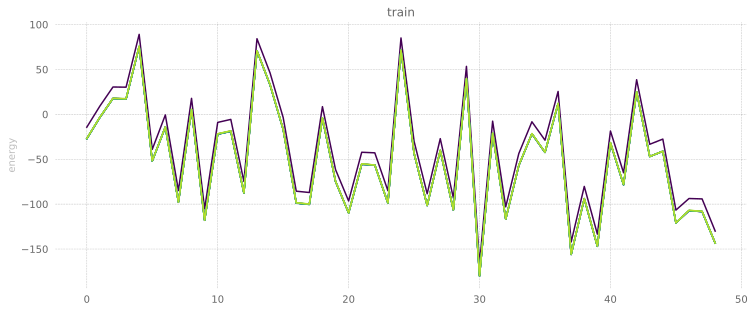

           Saving logprob to plots-4dSU3/train

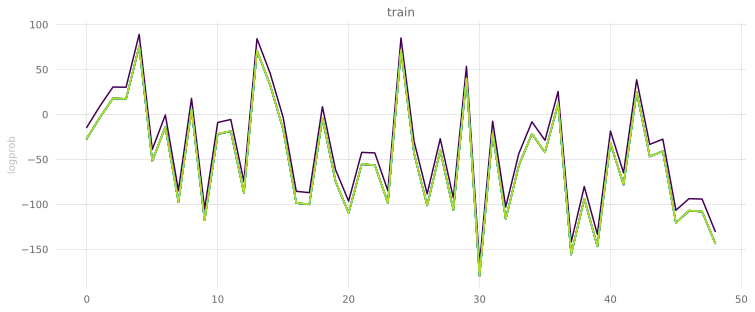

           Saving logdet to plots-4dSU3/train

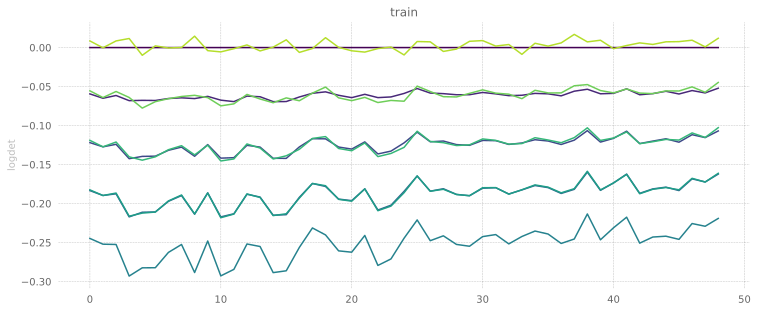

           Saving sldf to plots-4dSU3/train

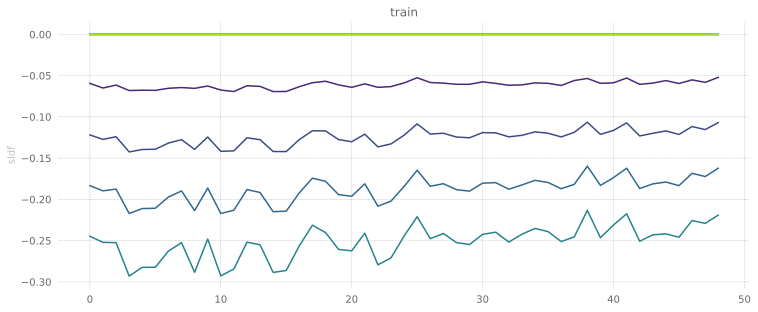

[07:57:41] Saving sldb to plots-4dSU3/train

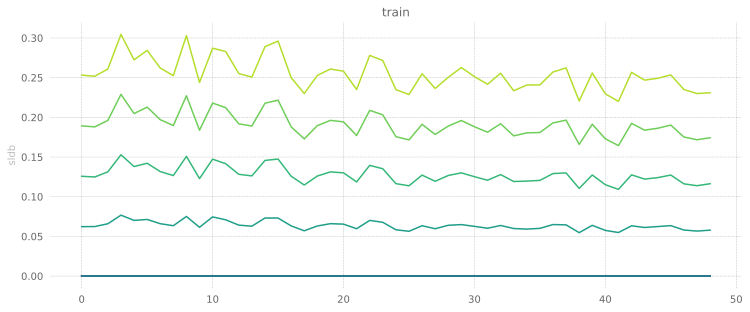

           Saving sld to plots-4dSU3/train

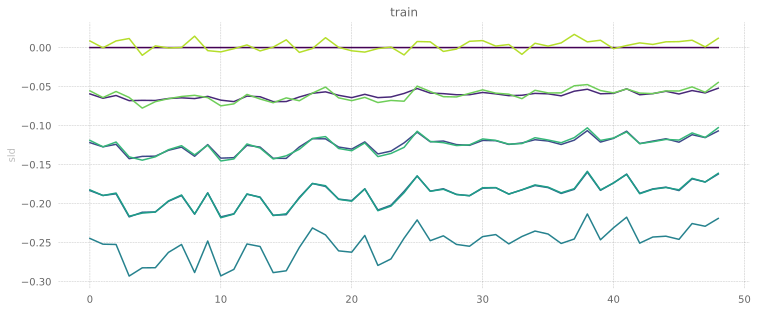

           Saving xeps to plots-4dSU3/train

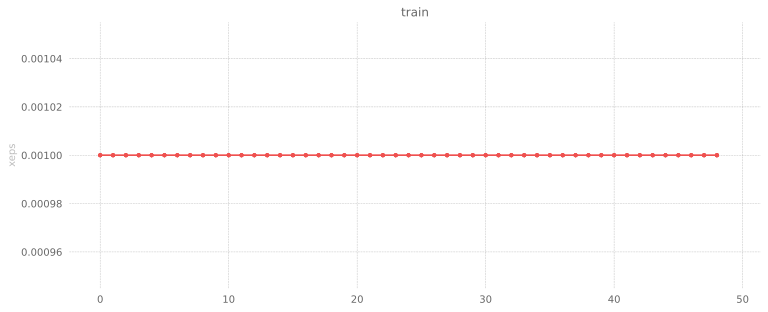

           Saving veps to plots-4dSU3/train

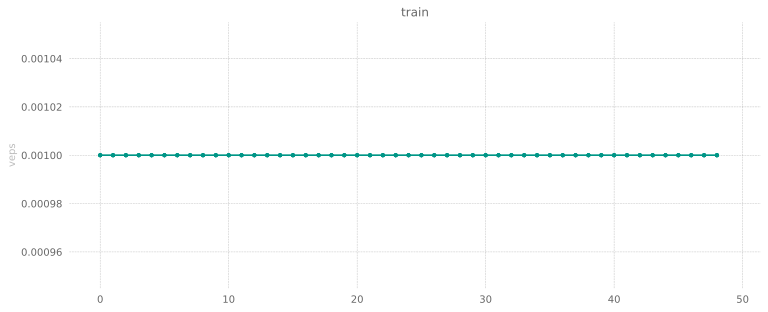

[07:57:42] Saving acc to plots-4dSU3/train

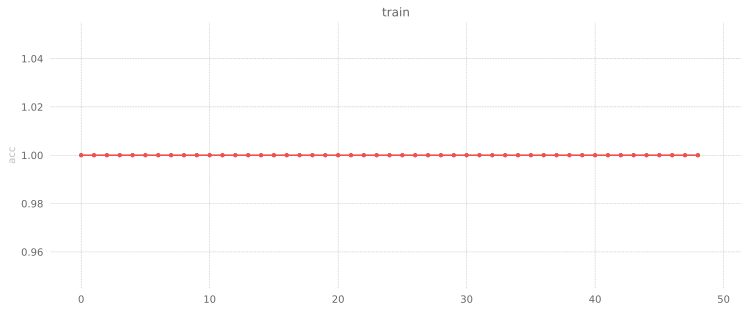

           Saving sumlogdet to plots-4dSU3/train

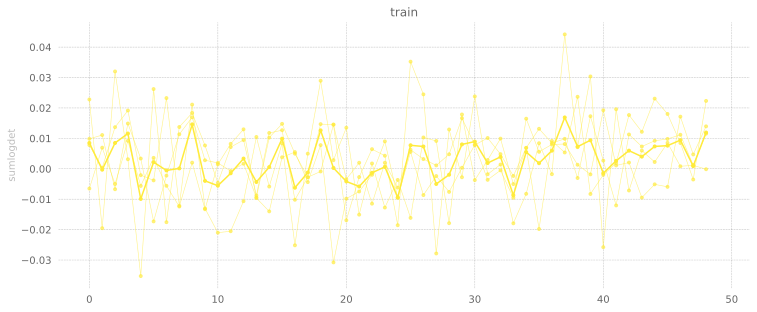

           Saving beta to plots-4dSU3/train

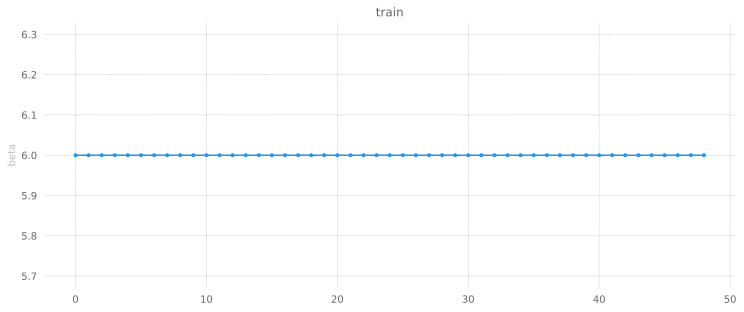

           Saving acc_mask to plots-4dSU3/train

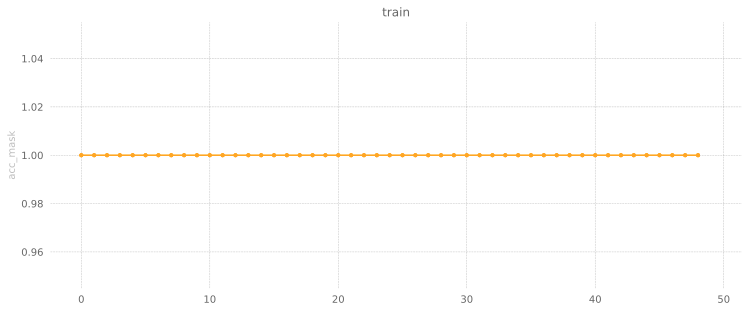

[07:57:43] Saving loss to plots-4dSU3/train

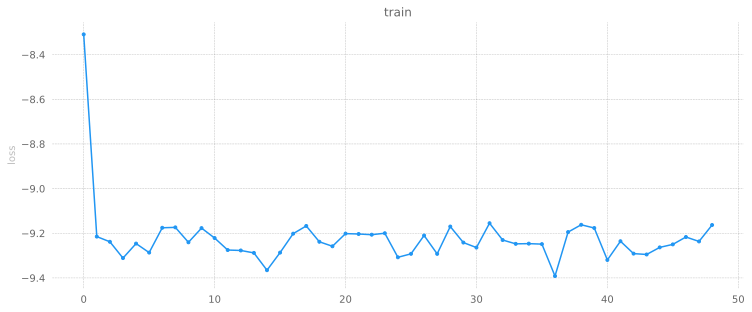

           Saving plaqs to plots-4dSU3/train

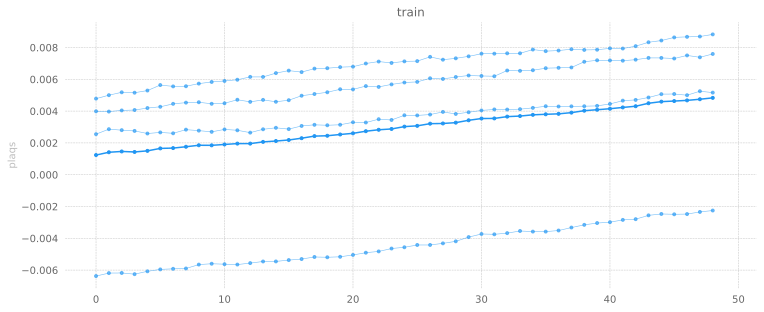

           Saving sinQ to plots-4dSU3/train

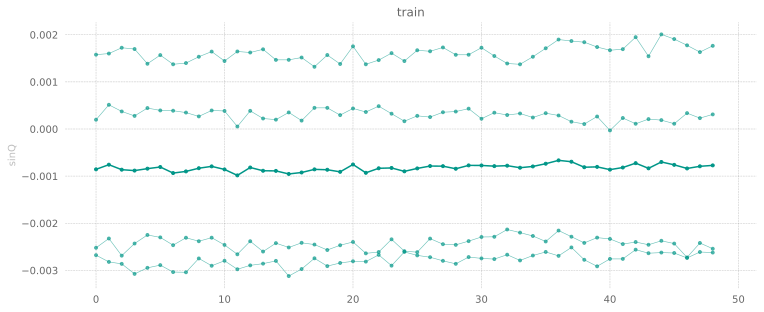

[07:57:44] Saving intQ to plots-4dSU3/train

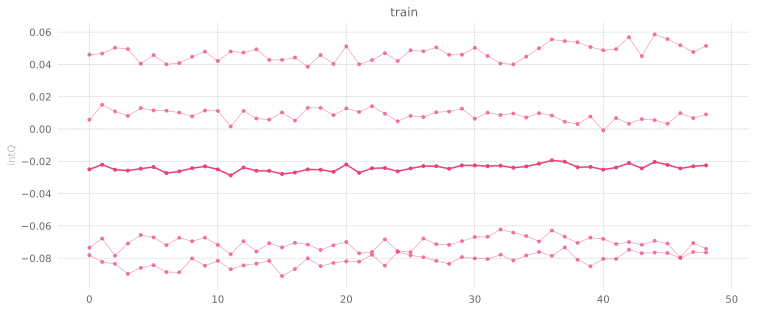

           Saving dQint to plots-4dSU3/train

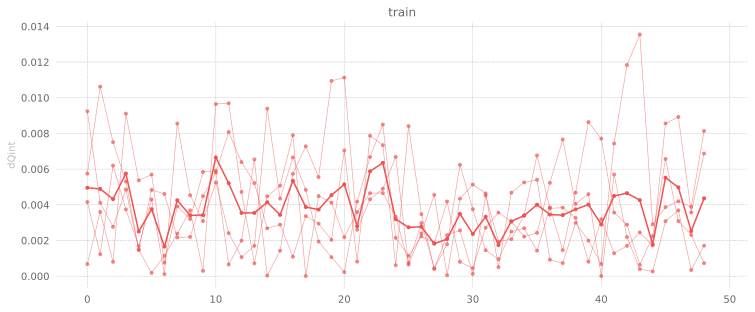

           Saving dQsin to plots-4dSU3/train

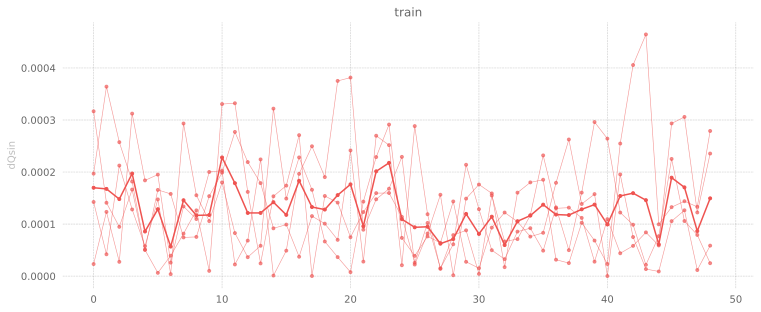

In [10]:
history = {}
x = state.x
for step in range(50):
    console.log(f'TRAIN STEP: {step}')
    x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
    if (step > 0 and step % 2 == 0):
        print_dict(metrics, grab=True)
    if (step > 0 and step % 1 == 0):
        for key, val in metrics.items():
            try:
                history[key].append(val)
            except KeyError:
                history[key] = [val]

x = ptExpSU3.trainer.dynamics.unflatten(x)
console.log(f"checkSU(x_train): {g.checkSU(x)}")
plot_metrics(history, title='train', marker='.')